In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience


import pims
import trackpy as tp
import av

from scipy.optimize import curve_fit

In [2]:
import time

In [3]:
t1 = time.time()

for i in range(int(1e6)):
    continue

t2 = time.time()
print(f"Time elapsed {t2-t1} s")

Time elapsed 0.026437997817993164 s


# Import video or single image as an array of frames

In [4]:
frames = pims.as_grey(pims.PyAVReaderTimed("videos/1.5g@30Hz_long.mp4"))#pims.PyAVReaderTimed("videos/1.5g@30Hz_long.mp4")#

show frame 0

(850, 478)
[[201.6491 203.6491 202.6491 ... 181.2942 181.2942 181.2942]
 [203.6491 206.6491 205.6491 ... 180.2942 180.2942 180.2942]
 [203.6491 207.6491 208.6491 ... 181.2942 181.2942 182.2942]
 ...
 [205.066  204.066  195.066  ...  36.5768  36.5768  36.5768]
 [205.2102 198.2102 197.2102 ...  38.148   38.148   38.148 ]
 [201.2102 195.2102 194.2102 ...  38.148   38.148   38.148 ]]


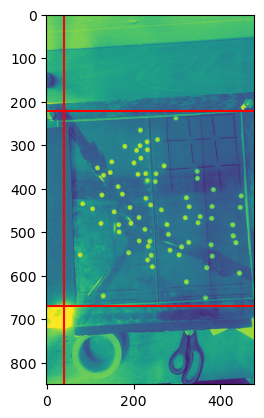

In [5]:
plt.imshow(frames[100])
plt.axvline(40, c='r')
plt.axhline(220, c='r')
plt.axhline(670, c='r')

print(frames[0].shape)
print(frames[0])

In [6]:
y = np.array([1, 2, 3, 5, 6, 7])
print(y[1:6])

[2 3 5 6 7]


# Crop video

In [7]:
print(type(frames))
new_frames = np.zeros(shape=len(frames), dtype=pims.Frame)

print(new_frames)
new_frames[0] = frames[0]
print(new_frames)

for i in range(len(new_frames)):
    new_frames[i] = frames[i][220:670, 40:-1]
#print(np.shape(new_frames))


<class 'slicerator.Pipeline'>
[0 0 0 ... 0 0 0]
[Frame([[201.6491, 203.6491, 202.6491, ..., 181.2942, 181.2942, 181.2942],
        [203.6491, 206.6491, 205.6491, ..., 180.2942, 180.2942, 180.2942],
        [203.6491, 207.6491, 208.6491, ..., 181.2942, 181.2942, 182.2942],
        ...,
        [205.066 , 204.066 , 195.066 , ...,  36.5768,  36.5768,  36.5768],
        [205.2102, 198.2102, 197.2102, ...,  38.148 ,  38.148 ,  38.148 ],
        [201.2102, 195.2102, 194.2102, ...,  38.148 ,  38.148 ,  38.148 ]])
 0 0 ... 0 0 0]


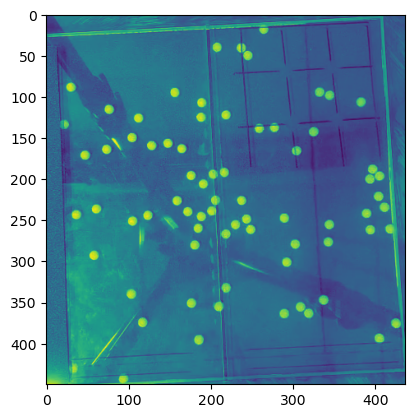

In [8]:
plt.imshow(new_frames[0])

crop unwanted parts from video

In [9]:
print(frames.frame_shape) # y, x, number of colours (I think), this is not modified by .as_grey()
print(len(frames))

print(new_frames[0].shape) # y, x


(850, 478, 3)
2139
(450, 437)


In [10]:
'''fps = 30
total_frames = len(new_frames)
duration = total_frames/fps

container = av.open("test.mp4", mode="w")

stream = container.add_stream("mpeg4", rate=fps)
stream.width = new_frames[0].shape[1]*2
stream.height = new_frames[0].shape[0]*2
stream.pix_fmt = "yuv420p"

for i in range(total_frames):

    img = new_frames[i]
    img = np.round(img)#.astype(np.uint16)
    frame = av.VideoFrame.from_ndarray(img, format="rgb24")
    for packet in stream.encode(frame):
        container.mux(packet)

# Flush stream
for packet in stream.encode():
    container.mux(packet)

# Close the file
container.close()'''

'fps = 30\ntotal_frames = len(new_frames)\nduration = total_frames/fps\n\ncontainer = av.open("test.mp4", mode="w")\n\nstream = container.add_stream("mpeg4", rate=fps)\nstream.width = new_frames[0].shape[1]*2\nstream.height = new_frames[0].shape[0]*2\nstream.pix_fmt = "yuv420p"\n\nfor i in range(total_frames):\n\n    img = new_frames[i]\n    img = np.round(img)#.astype(np.uint16)\n    frame = av.VideoFrame.from_ndarray(img, format="rgb24")\n    for packet in stream.encode(frame):\n        container.mux(packet)\n\n# Flush stream\nfor packet in stream.encode():\n    container.mux(packet)\n\n# Close the file\ncontainer.close()'

In [11]:
#frames1= crop_frames(frames, x_range=(40,-1), y_range=(220,670))
'''frames1 = pims.process.crop(frames, ((40, 180), (40, 0), (0, 0)))

print(frames1.frame_shape)
print(frames1.shape)'''

'frames1 = pims.process.crop(frames, ((40, 180), (40, 0), (0, 0)))\n\nprint(frames1.frame_shape)\nprint(frames1.shape)'

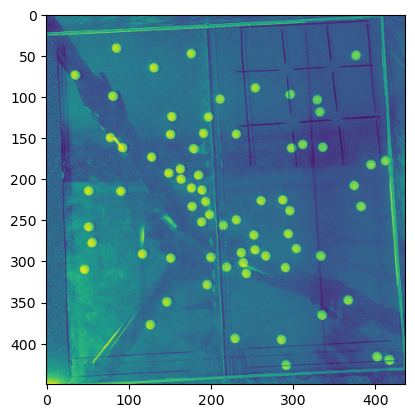

In [12]:
for i in range(len(new_frames)):
    if i % 100 == 0:
        plt.imshow(new_frames[i])
        #plt.show()

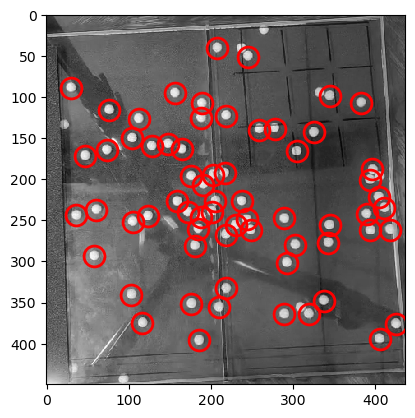

<Axes: >

In [13]:
# locates bright features with diameter of 3 pixels
f = tp.locate(new_frames[0], 13, threshold=0, minmass=3000)
f.head()  # shows the first few rows of data
	
tp.annotate(f, new_frames[0])

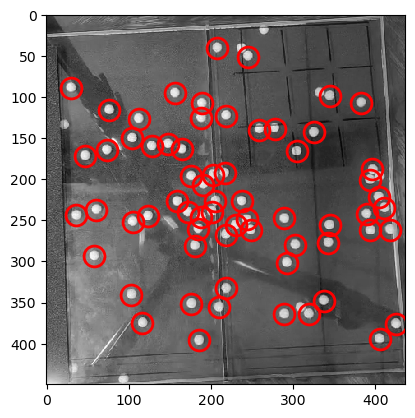

In [14]:
fig, axe = plt.subplots()

tp.annotate(f, new_frames[0], ax=axe)
plt.savefig("figs/tracking0.png", dpi=300)

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

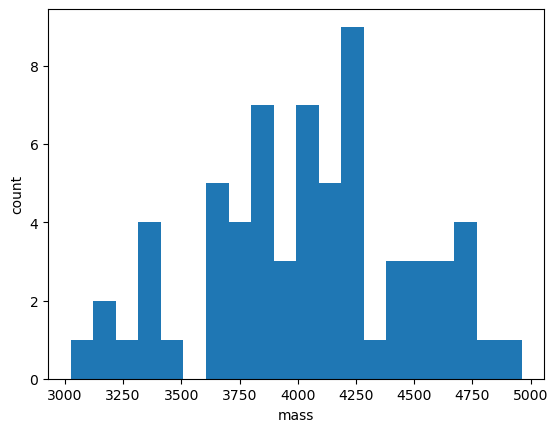

In [15]:
# clearly many of these circles are wrong, we look at total brightness ('mass') of these points
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

# Track on entire video

In [16]:
f = tp.batch(new_frames, 13, threshold=0, minmass=3000)

Frame 2138: 65 features


before: 18052
after:
- memory=3 : 3125
- memory=5 : 3086
- memory=7 : 3062
- memory=10 : 3042

In [17]:
# tp.quiet()  # Turn off progress reports for best performance
t = tp.link(f, 5, memory=3) # this tracks the location of each particle by establishing continuity from frame to frame
#t.head()

t1 = tp.filter_stubs(t, 10)
#t1 = t.copy()
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Frame 2138: 65 trajectories present.
Before: 18052
After: 3125


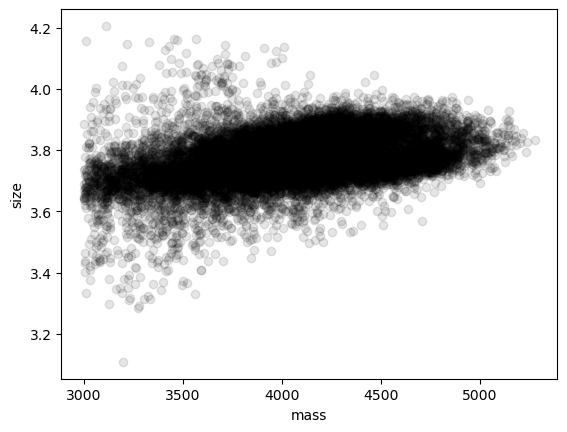

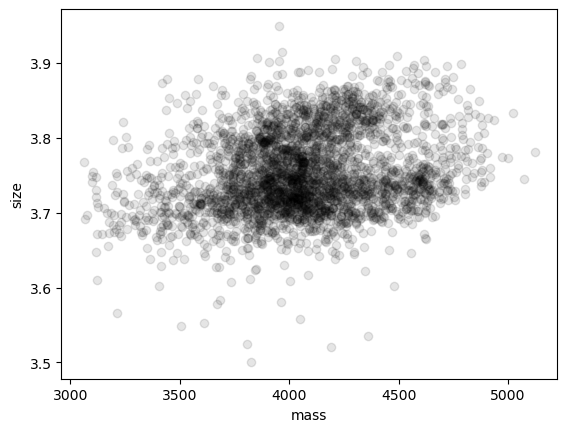

In [18]:
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass


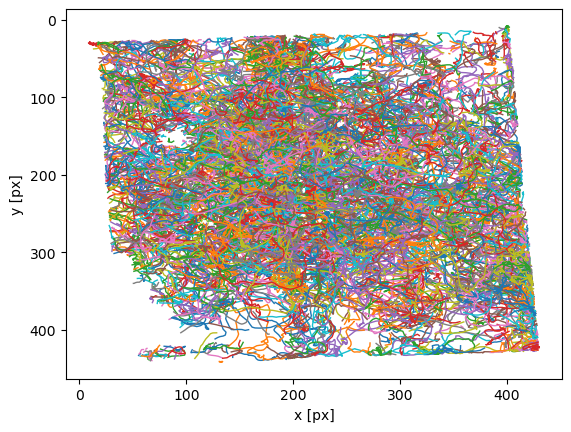

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [19]:
plt.figure()
tp.plot_traj(t1)

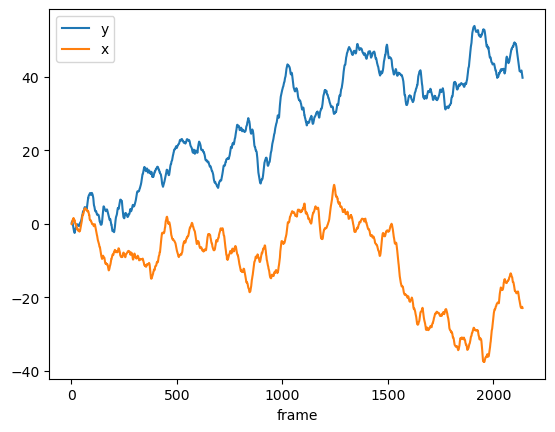

In [20]:
d = tp.compute_drift(t1)
d.plot()
plt.show()

don't subtract drift. There doesn't look to be an overall drift behaviour. Besides, assuming the table is level, there should in principle be no overall bulk drift, so I believe we should interpret these as random bulk fluctations for particle movement

# Compute mean square displacement

In [21]:
im = tp.imsd(t1, 1., 30)  # microns per pixel = 1 (just fro now), frames per second = 30



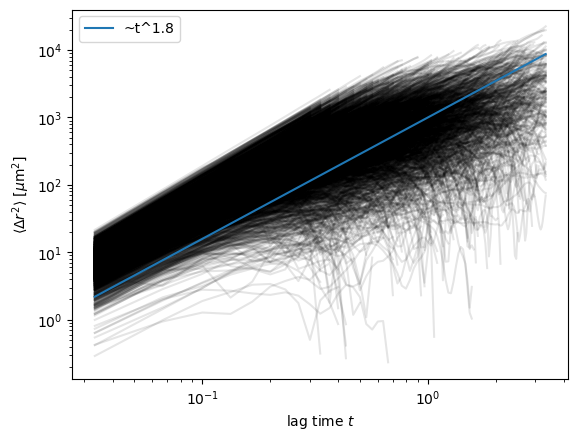

In [22]:
def poly_model(x, alpha, a):
    return a*x**alpha

fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.plot(im.index, poly_model(im.index, 1.8, 1e3), label=fr"~t^1.8")
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


In [23]:
em = tp.emsd(t1, 1., 30) # microns per pixel = 1., frames per second = 30


In [24]:
print(len(em.index))

100


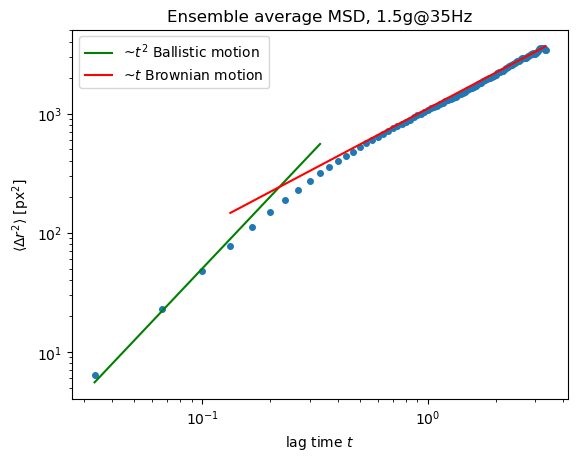

In [25]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o', markersize=4)
ax.plot(em.index[:10], poly_model(em.index[:10], 2, 5000), label=f"~$t^2$ Ballistic motion", c='green') # Ballistic motion at short timescales
ax.plot(em.index[3:], poly_model(em.index[3:], 1, 1.1e3), label=f"~$t$ Brownian motion", c='red') # Brownian motion at long timescales
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [px$^2$]',
       xlabel='lag time $t$')
ax.set_title("Ensemble average MSD, 1.5g@35Hz")
ax.legend()
#plt.savefig("figs/ensemble_MSD_1.5g@35Hz.png", dpi=300)
plt.show()



In [26]:
print(max(em.index))

3.3333333333333335


In [27]:
print(t1[t1['frame']==5])

                      y           x         mass      size       ecc  \
frame_index                                                            
5            264.537794  345.209415  4350.138839  3.797938  0.046903   
5            264.481047  218.232057  3410.934150  3.639202  0.049730   
5            261.810143  186.171642  4089.576811  3.666408  0.039802   
5            256.721960  409.861059  4166.367132  3.802981  0.044500   
5            249.470017   60.951936  3584.532781  3.679507  0.008997   
5            248.117224  243.734529  4062.011055  3.692308  0.017222   
5            242.017346  300.198288  4256.612167  3.750764  0.030672   
5            240.993078  130.548947  4314.368989  3.714358  0.008928   
5            267.870543  248.537395  4142.083013  3.793817  0.025650   
5            242.756335   31.809162  3975.703986  3.666808  0.021928   
5            254.774343  228.984726  3609.473227  3.644663  0.067091   
5            280.007332  341.020441  4430.867125  3.847302  0.05

In [28]:

particle0 = t1[t1['particle']==0]
print(particle0)

                     y           x         mass      size       ecc  \
frame_index                                                           
0            40.000325  207.421253  4169.764765  3.796250  0.008172   
1            39.856192  208.161556  4202.261390  3.792223  0.014046   
2            40.241476  208.385274  4182.574191  3.825742  0.008486   
3            43.860632  208.420791  4164.662034  3.821202  0.019652   
4            45.847741  208.805221  4153.943409  3.801364  0.011759   
...                ...         ...          ...       ...       ...   
110          54.815424  190.662284  4070.507404  3.784915  0.004198   
111          54.649295  190.849895  4041.195046  3.780136  0.021414   
112          55.583909  189.503279  3811.782535  3.828220  0.016179   
113          56.888245  187.897747  3833.704331  3.822799  0.006939   
114          59.832638  187.512475  3305.578054  3.674968  0.018420   

                signal    raw_mass        ep  frame  particle  
frame_index 

print(particle0[particle0['frame']==0])
for i in range(len(new_frames)):
    tp.annotate(particle0[particle0['frame']==i], new_frames[i])
    plt.show()
    print(i)
    input()
    

# create array listing position of each particle

In [29]:
particle_num = np.max(t1['particle'])
print(f"{particle_num = }")
particle_info = [t1[t1['particle']==i] for i in range(particle_num+1)]

particle_num = 17983


In [30]:
particle_info[8][particle_info[8]['frame']==5]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame_index,,,,,,,,,,
5,254.774343,228.984726,3609.473227,3.644663,0.067091,52.178038,23667.1225,0.045132,5,8


# which particle do we distinguish for the longest amount of time?

In [31]:
fps = 30.

frames_tracked = np.array([len(particle_info[i]) for i in range(len(particle_info))])
print(frames_tracked)
time_tracked = frames_tracked * 1/fps
print(np.max(time_tracked))

[113  14  14 ...   0   0  10]
8.466666666666667


# Compute particle velocities

### Strategy 1
Compute velocities for each individual particle first, then compute an ensemble average for each time_step

need to account for jumped frames

In [32]:
print(t1.columns)

Index(['y', 'x', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep', 'frame',
       'particle'],
      dtype='object')


In [33]:
particle_num = np.max(t1['particle'])

tv = t1.copy()
#print(tv)
tv.insert(len(tv.columns), 'speed', 0.)

# do it for 1 particle first
p0 = tv[tv['particle']==0]
p0_frames = p0['frame']

p0_intervals = [] # array of tuples containing start and end for each continous interval where particle is detected
start = True
first_start = True
prev, curr = 0, 0
for i in p0_frames: # this actually serves as an index, i.e if p0 is not detected during frame 14, then there is no element 14, only an element 13 then 15
    if first_start: prev = i; first_start = False
    curr = i
    if curr-prev > 1:
        # frame jumping
        print("frame skip: ",prev, curr)
        start = True

    if start:
        if len(p0_intervals) != 0: p0_intervals[-1][1] = prev
        p0_intervals.append([curr, -69]) # error will occur if -69 not overwritten
    start = False
    prev = curr
p0_intervals[-1][1] = curr
print(p0_intervals)
# iterate through every particle
#for i in range(particle_num+1):
#    p = tv[tv['particle']==i]

#    p_frames = np.max(tv')



frame skip:  13 16
[[0, 13], [16, 114]]


In [34]:
def dist(y1, x1, y2, x2): # compute 2D euclidean norm:
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [35]:
print(p0['y'][0], p0['x'][0], p0['y'][1], p0['x'][1])
print(dist(p0['y'][0], p0['x'][0], p0['y'][1], p0['x'][1]))

40.00032472804027 207.42125345023544 39.856192060850965 208.16155613659774
0.7542030848427618


In [36]:
for i_start, i_end in p0_intervals:
    if i_end-i_start < 2: print(f"Interval length too short: {i_end-i_start=}"); continue
    for i in range(i_start, i_end+1):
        if i == i_start: # start of the interval, differentiate over single time_step
            p0.loc[i, 'speed'] = dist(p0['y'][i], p0['x'][i], p0['y'][i+1], p0['x'][i+1]) # px/frame
            #print(p0)
        elif i == i_end: # end of interval
            p0.loc[i, 'speed'] = dist(p0['y'][i-1], p0['x'][i-1], p0['y'][i], p0['x'][i])
        else: # neither start nor beginner, we can average speed over 2 frames for more numerical stability
            p0.loc[i, 'speed'] = dist(p0['y'][i-1], p0['x'][i-1], p0['y'][i+1], p0['x'][i+1])/2

print(p0)

                     y           x         mass      size       ecc  \
frame_index                                                           
0            40.000325  207.421253  4169.764765  3.796250  0.008172   
1            39.856192  208.161556  4202.261390  3.792223  0.014046   
2            40.241476  208.385274  4182.574191  3.825742  0.008486   
3            43.860632  208.420791  4164.662034  3.821202  0.019652   
4            45.847741  208.805221  4153.943409  3.801364  0.011759   
...                ...         ...          ...       ...       ...   
110          54.815424  190.662284  4070.507404  3.784915  0.004198   
111          54.649295  190.849895  4041.195046  3.780136  0.021414   
112          55.583909  189.503279  3811.782535  3.828220  0.016179   
113          56.888245  187.897747  3833.704331  3.822799  0.006939   
114          59.832638  187.512475  3305.578054  3.674968  0.018420   

                signal    raw_mass        ep  frame  particle     speed  
fr

## now time to compute velocities

In [37]:
print(tv.iloc[2]) # iloc gives you the i'th row (0 indexing)

y             242.070792
x             389.510234
mass         4217.494659
size            3.786829
ecc             0.032467
signal         53.484562
raw_mass    22490.743100
ep              0.052943
frame           0.000000
particle        2.000000
speed           0.000000
Name: 0, dtype: float64


because of how this data structure works, I think simplest is to first compute, for each particle num, the indices at which their elements appear

In [38]:
# first do for a single particle

p0_indices = []
for i in range(len(tv)):
    if tv.iloc[i]['particle'] == 0: p0_indices.append(i)

print(p0_indices)

print(tv.iloc[p0_indices[59]])

[0, 78, 122, 163, 211, 261, 310, 360, 410, 463, 518, 570, 619, 670, 830, 888, 944, 1000, 1056, 1113, 1173, 1233, 1294, 1353, 1412, 1467, 1526, 1582, 1639, 1695, 1749, 1806, 1864, 1921, 1977, 2034, 2093, 2149, 2206, 2261, 2318, 2376, 2434, 2489, 2545, 2599, 2656, 2710, 2766, 2823, 2883, 2940, 2998, 3056, 3117, 3182, 3244, 3294, 3353, 3409, 3467, 3526, 3586, 3642, 3698, 3752, 3805, 3857, 3915, 3972, 4028, 4085, 4137, 4192, 4245, 4295, 4346, 4398, 4448, 4490, 4535, 4579, 4624, 4666, 4712, 4761, 4811, 4861, 4910, 4966, 5022, 5078, 5135, 5195, 5250, 5304, 5363, 5421, 5480, 5545, 5605, 5666, 5727, 5786, 5850, 5903, 5962, 6025, 6086, 6146, 6203, 6259, 6311]
y              49.414553
x             185.236031
mass         3925.283880
size            3.762088
ecc             0.033842
signal         52.540765
raw_mass    23642.235400
ep              0.063454
frame          61.000000
particle        0.000000
speed           0.000000
Name: 61, dtype: float64


In [39]:
tv = t1.copy()
tv.insert(len(tv.columns), 'speed', 0.)
tv.insert(len(tv.columns), 'vx', 0.)
tv.insert(len(tv.columns), 'vy', 0.)
print(tv)

                      y           x         mass      size       ecc  \
frame_index                                                            
0             40.000325  207.421253  4169.764765  3.796250  0.008172   
0            243.533605   35.894495  3898.279837  3.708532  0.040265   
0            242.070792  389.510234  4217.494659  3.786829  0.032467   
0            247.592782  289.359591  4108.155966  3.777056  0.014753   
0            244.664142  123.200081  4200.907674  3.705463  0.008596   
...                 ...         ...          ...       ...       ...   
2138         188.517178  220.750631  4142.546437  3.687084  0.016645   
2138         198.680878  101.154672  4496.015868  3.788739  0.038702   
2138         207.023847  177.323987  4124.890981  3.756755  0.006561   
2138         146.895087   40.403157  4062.916728  3.700342  0.025287   
2138         432.997925  272.503162  3646.392097  3.738289  0.064526   

                signal    raw_mass        ep  frame  particle  

In [40]:


def find_complete_intervals(df, p_num):
    p_frames = df.loc[df['particle']==p_num, 'frame']
    p_intervals = [] # array of tuples containing start and end for each continous interval where particle is detected
    start = True
    first_start = True
    prev, curr = 0, 0
    for i in p_frames: # this actually serves as an index, i.e if p0 is not detected during frame 14, then there is no element 14, only an element 13 then 15
        if first_start: prev = i; first_start = False
        curr = i
        if curr-prev > 1:
            # frame jumping
            #print("frame skip: ",prev, curr)
            start = True

        if start:
            if len(p_intervals) != 0: p_intervals[-1][1] = prev
            p_intervals.append([curr, -69]) # error will occur if -69 not overwritten
        start = False
        prev = curr
    #print(p_intervals)
    if len(p_intervals) != 0: p_intervals[-1][1] = curr
    #else: print("Intervals too short", p_intervals)
    #print(p_intervals)
    return p_intervals

#tv.loc[(tv['particle']==0) & (tv['frame']==3), ['speed']] = 0.9 # assigning a specific frame  

def dist(y1, x1, y2, x2): # compute 2D euclidean norm:
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def compute_speeds(df, p_num, p_intervals) : # compute speeds of single particle over a complete interval
    short_count = 0
    p = df.loc[df['particle']==p_num]
    for i_start, i_end in p_intervals:
        if i_end-i_start == 0: 
            #print(f"Interval length too short: {i_end-i_start=}")
            df.loc[(df['particle']==p_num) & (tv['frame']==i_start), 'speed'] == None
            df.loc[(df['particle']==p_num) & (tv['frame']==i_start), 'vx'] == None
            df.loc[(df['particle']==p_num) & (tv['frame']==i_start), 'vy'] == None
            short_count += 1
            continue
        for i in range(i_start, i_end+1): # i is a frame_index
            if i == i_start: # start of the interval, differentiate over single time_step
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'speed'] = dist(p['y'][i], p['x'][i], p['y'][i+1], p['x'][i+1]) # px/frame
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vx'] =  p.loc[i+1, 'x'] - p.loc[i, 'x'] # px/frame 
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vy'] =  p.loc[i+1, 'y'] - p.loc[i, 'y'] # px/frame 
                #print(p0)
            elif i == i_end: # end of interval
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'speed'] = dist(p['y'][i-1], p['x'][i-1], p['y'][i], p['x'][i])
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vx'] =  p.loc[i, 'x'] - p.loc[i-1, 'x'] # px/frame 
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vy'] =  p.loc[i, 'y'] - p.loc[i-1, 'y'] # px/frame 
            else: # neither start nor beginner, we can average speed over 2 frames for more numerical stability
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'speed'] = dist(p['y'][i-1], p['x'][i-1], p['y'][i+1], p['x'][i+1])/2
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vx'] =  (p.loc[i+1, 'x'] - p.loc[i-1, 'x'])/2 # px/frame 
                df.loc[(df['particle']==p_num) & (tv['frame']==i), 'vy'] = (p.loc[i+1, 'y'] - p.loc[i-1, 'y'])/2 # px/frame 
    return df, short_count


short_count = 0
for i in range(particle_num+1):
    p = tv[tv['particle']==i]
    p_intervals = find_complete_intervals(tv, p_num=i)
    #print(p_intervals)
    tv, sc = compute_speeds(tv, i, p_intervals)
    short_count += sc
    #print(i, p)



# velocity distribution

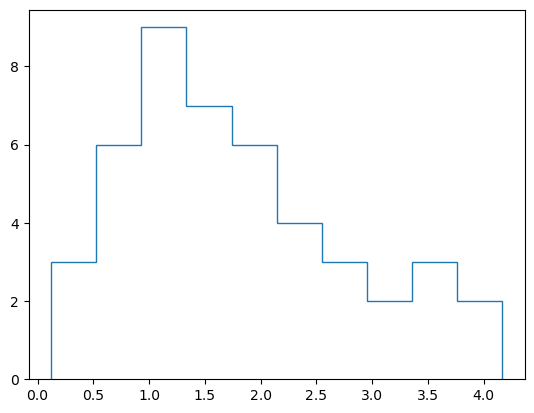

In [41]:
# lets look at frame 0
frame0 = tv.loc[tv['frame']==1]
v0 = frame0['speed']

#print(frame0)
#print(v0)

counts, bins = np.histogram(v0)
plt.stairs(counts, bins)

In [42]:
print(tv)

                      y           x         mass      size       ecc  \
frame_index                                                            
0             40.000325  207.421253  4169.764765  3.796250  0.008172   
0            243.533605   35.894495  3898.279837  3.708532  0.040265   
0            242.070792  389.510234  4217.494659  3.786829  0.032467   
0            247.592782  289.359591  4108.155966  3.777056  0.014753   
0            244.664142  123.200081  4200.907674  3.705463  0.008596   
...                 ...         ...          ...       ...       ...   
2138         188.517178  220.750631  4142.546437  3.687084  0.016645   
2138         198.680878  101.154672  4496.015868  3.788739  0.038702   
2138         207.023847  177.323987  4124.890981  3.756755  0.006561   
2138         146.895087   40.403157  4062.916728  3.700342  0.025287   
2138         432.997925  272.503162  3646.392097  3.738289  0.064526   

                signal    raw_mass        ep  frame  particle  

# check wether granular temperature remains stable between frames

In [43]:
# number of frames


print(tv['frame'])

frame_index
0          0
0          0
0          0
0          0
0          0
        ... 
2138    2138
2138    2138
2138    2138
2138    2138
2138    2138
Name: frame, Length: 109120, dtype: int64


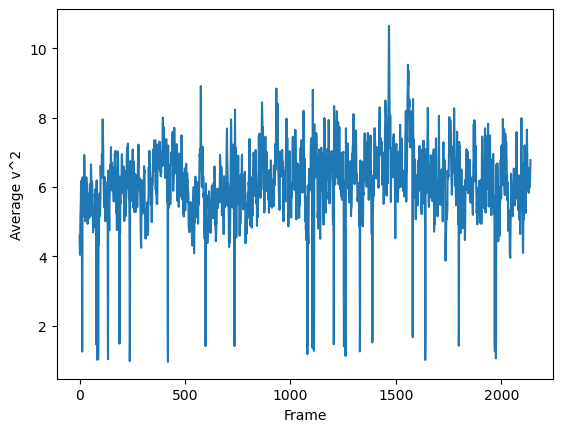

In [44]:
T = np.zeros(np.max(tv['frame'])+1)
for i in range(np.max(tv['frame'])+1):
    frame = tv.loc[tv['frame']==i]
    vf = frame['speed']
    vf_fix = np.array([e for e in vf if not np.isnan(e)])

    T[i] = np.mean(vf_fix**2)

frame_num = np.arange(0, np.max(tv['frame'])+1)

plt.plot(frame_num, T)
plt.xlabel("Frame")
plt.ylabel("Average v^2")
plt.show()

# check PSD of T

/Users/hervesv/opt/anaconda3/envs/IPT/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hervesv/opt/anaconda3/envs/IPT/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


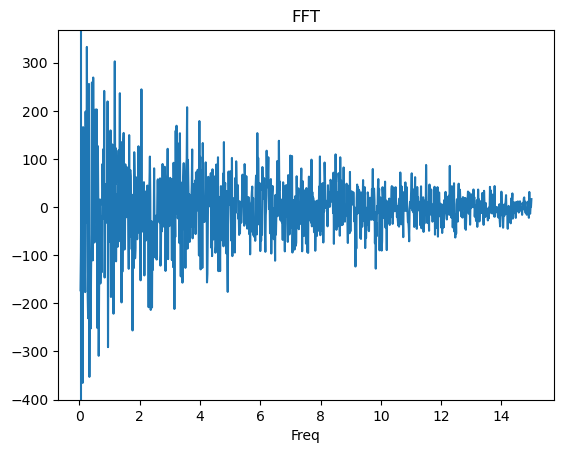

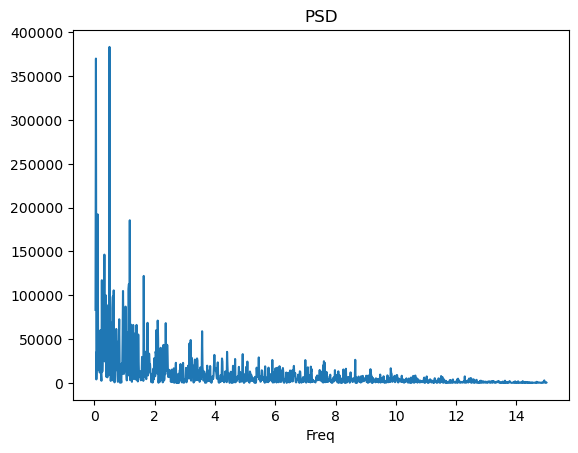

In [45]:
fps = 30
T_fft = np.fft.rfft(T)*2 # to normalise PSD
f_space = np.fft.rfftfreq(len(T), d=1/fps)

# cut out dc

delta_f = f_space[1]-f_space[0]
thresh_index = int(0.05 / delta_f)
plt.plot(f_space[thresh_index:], T_fft[thresh_index:])
plt.axvline(0.05)
plt.xlabel("Freq")
plt.title("FFT")
plt.show()

T_psd = np.abs(T_fft)**2

plt.plot(f_space[thresh_index:], T_psd[thresh_index:])
plt.xlabel("Freq")
plt.title("PSD")
plt.show()


not enough for statistics, we probably have to do an ensemble average over all the frames. I guess we have to assume that granular temperature is constant

In [46]:
v = tv['speed']
#print(v)
#counts, bins = np.histogram(v)
#plt.stairs(counts, bins)
v_fix = [e for e in v if not np.isnan(e)]
v_fix = np.array(v_fix)

vx = tv['vx']
vx_fix = [e for e in vx if not np.isnan(e)]
vx_fix = np.array(vx_fix)

vy = tv['vy']
vy_fix = [e for e in vy if not np.isnan(e)]
vy_fix = np.array(vy_fix)



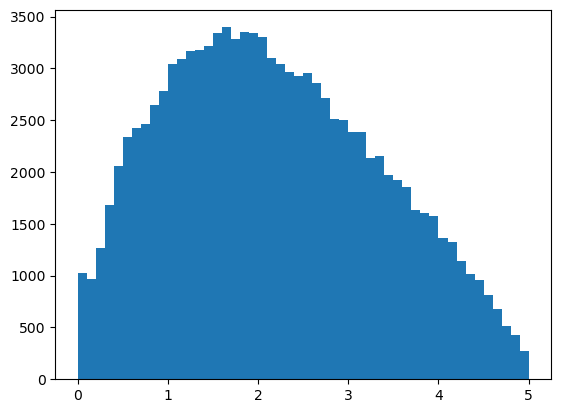

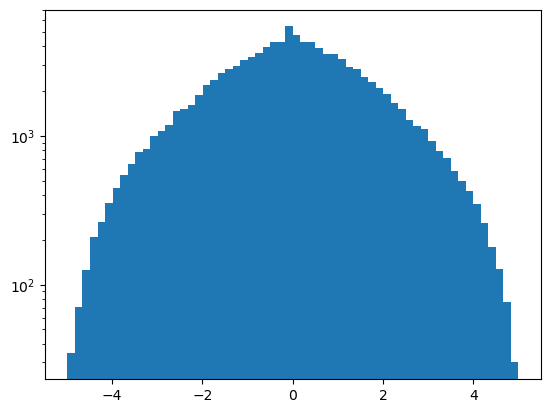

In [47]:
plt.hist(v_fix, 50)
plt.show()

plt.hist(vx_fix, 60)
plt.yscale('log')
plt.show()

# Fit with maxwell boltzmann distribution


p(v_x) = A*exp(-vx^2 / T)

In [48]:
# For simplicity, define granular temperature as the mean velocity-squared
# all other scaling factors will be absorbed into fitting parameters

Tg = np.mean(v_fix**2)
def maxwellian(vx, sigma): # for velocity component
    return 1/(np.sqrt(2*np.pi*sigma**2))*np.exp(-vx**2/(2*sigma**2))

print(Tg)

6.0894467674047705


[-5.         -4.94974874 -4.89949749 -4.84924623 -4.79899497 -4.74874372
 -4.69849246 -4.64824121 -4.59798995 -4.54773869 -4.49748744 -4.44723618
 -4.39698492 -4.34673367 -4.29648241 -4.24623116 -4.1959799  -4.14572864
 -4.09547739 -4.04522613 -3.99497487 -3.94472362 -3.89447236 -3.84422111
 -3.79396985 -3.74371859 -3.69346734 -3.64321608 -3.59296482 -3.54271357
 -3.49246231 -3.44221106 -3.3919598  -3.34170854 -3.29145729 -3.24120603
 -3.19095477 -3.14070352 -3.09045226 -3.04020101 -2.98994975 -2.93969849
 -2.88944724 -2.83919598 -2.78894472 -2.73869347 -2.68844221 -2.63819095
 -2.5879397  -2.53768844 -2.48743719 -2.43718593 -2.38693467 -2.33668342
 -2.28643216 -2.2361809  -2.18592965 -2.13567839 -2.08542714 -2.03517588
 -1.98492462 -1.93467337 -1.88442211 -1.83417085 -1.7839196  -1.73366834
 -1.68341709 -1.63316583 -1.58291457 -1.53266332 -1.48241206 -1.4321608
 -1.38190955 -1.33165829 -1.28140704 -1.23115578 -1.18090452 -1.13065327
 -1.08040201 -1.03015075 -0.9798995  -0.92964824 -0.

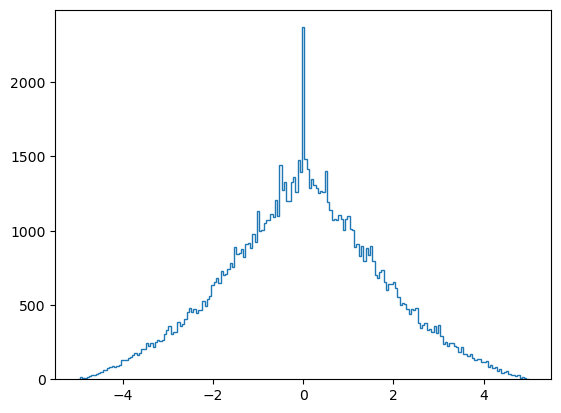

In [60]:
counts, bins = np.histogram(vx, bins=np.linspace(-5, 5, 200), density=False) # normalised
plt.stairs(counts, bins)
#plt.yscale('log')
#print(bins)

print(bins)

60 59
1.6994475121760995


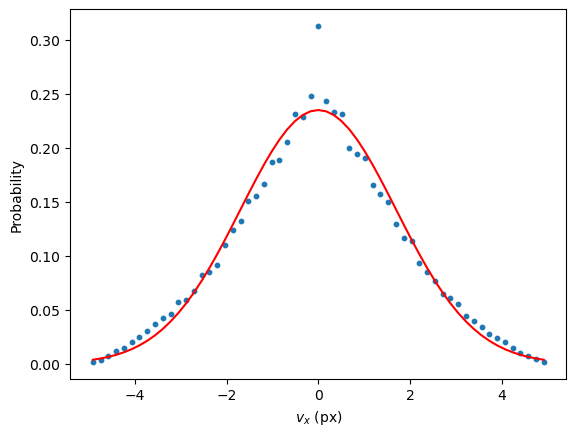

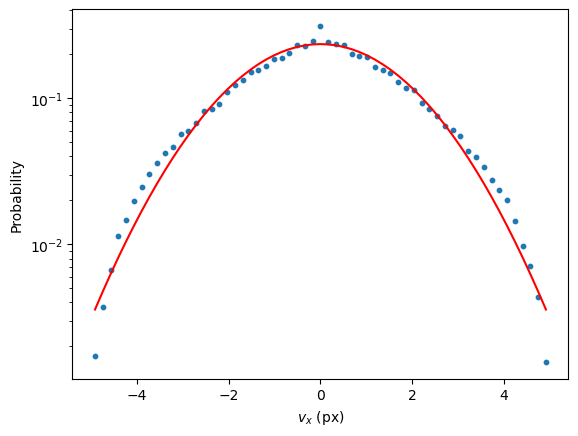

In [50]:
v_space = np.array([(bins[i-1]+bins[i])/2 for i in range(1, len(bins))])
print(len(bins), len(counts))

popt, pcov = curve_fit(maxwellian, v_space, counts)

print(*popt)
plt.plot(v_space, maxwellian(v_space, popt[0]), c='r')
plt.scatter(v_space, counts, s=10)
plt.xlabel("$v_x$ (px)")
plt.ylabel("Probability")
#plt.title("$v_x$ distribution (lin)")
plt.savefig("figs/v_lin.png", dpi=300)
plt.show()

plt.plot(v_space, maxwellian(v_space, popt[0]), c='r')
plt.scatter(v_space, counts, s=10)
plt.xlabel("$v_x$ (px)")
plt.ylabel("Probability")
plt.yscale('log')
#plt.title("$v_x$ distribution (log)")
plt.savefig("figs/v_log.png", dpi=300)
plt.show()




50 49
1.6984848404338684


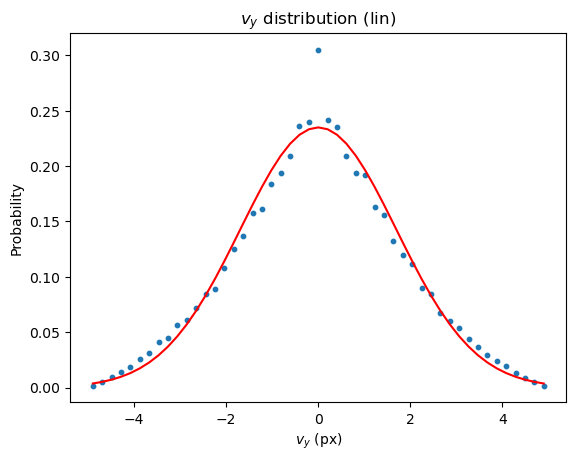

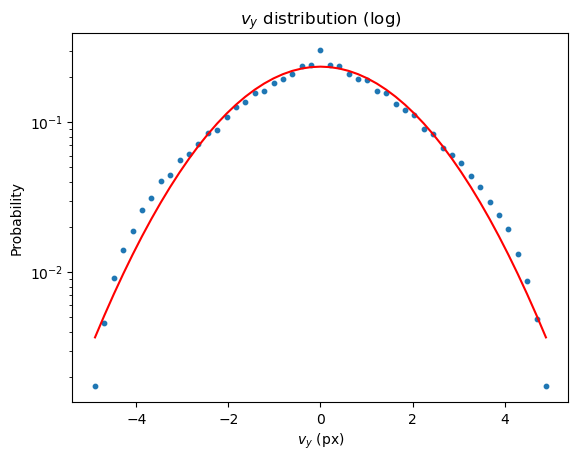

In [51]:
counts, bins = np.histogram(vx, bins=np.linspace(-5, 5, 50), density=True) # normalised
#plt.stairs(counts, bins)

v_space = np.array([(bins[i-1]+bins[i])/2 for i in range(1, len(bins))])
print(len(bins), len(counts))

popt, pcov = curve_fit(maxwellian, v_space, counts)

print(*popt)
plt.plot(v_space, maxwellian(v_space, popt[0]), c='r')
plt.scatter(v_space, counts, s=10)
plt.xlabel("$v_y$ (px)")
plt.ylabel("Probability")
plt.title("$v_y$ distribution (lin)")
#plt.savefig("figs/vy_lin.png", dpi=300)
plt.show()

plt.plot(v_space, maxwellian(v_space, popt[0]), c='r')
plt.scatter(v_space, counts, s=10)
plt.xlabel("$v_y$ (px)")
plt.ylabel("Probability")
plt.yscale('log')
plt.title("$v_y$ distribution (log)")
#plt.savefig("figs/vy_log.png", dpi=300)
plt.show()

In [52]:
print(short_count)

print(tv)

303
                      y           x         mass      size       ecc  \
frame_index                                                            
0             40.000325  207.421253  4169.764765  3.796250  0.008172   
0            243.533605   35.894495  3898.279837  3.708532  0.040265   
0            242.070792  389.510234  4217.494659  3.786829  0.032467   
0            247.592782  289.359591  4108.155966  3.777056  0.014753   
0            244.664142  123.200081  4200.907674  3.705463  0.008596   
...                 ...         ...          ...       ...       ...   
2138         188.517178  220.750631  4142.546437  3.687084  0.016645   
2138         198.680878  101.154672  4496.015868  3.788739  0.038702   
2138         207.023847  177.323987  4124.890981  3.756755  0.006561   
2138         146.895087   40.403157  4062.916728  3.700342  0.025287   
2138         432.997925  272.503162  3646.392097  3.738289  0.064526   

                signal    raw_mass        ep  frame  partic

In [53]:
# returns all the indices of rows featuring particle with number p_num
def get_p_indices(df, p_num):
    #num_frames = len(df[df['particle']==p_num])
    #p_indices = []#np.zeros(num_frames, dtype=int)
    #c = 0
    #for i in range(len(df)): # for loop notoriously slow
    #    if df.iloc[i]['particle'] == p_num: 
    #        e=1
            #p_indices.append(i)
            #p_indices[c] = i
            #c += 1
    p_indices = df[df['particle']==p_num].index

    return p_indices


# returns a list of all the un-interupted time intervals where particle is tracked (index of start and end of interval in df)
# returned p_intervals object is not the same as before
def find_complete_intervals(df, p_indices):
    p_intervals = []
    start_index = p_indices[0]
    curr, prev = 0, 0
    for i in range(1, len(p_indices)): # skip first one
        if df.iloc[p_indices[i]]['frame']-df.iloc[p_indices[i-1]]['frame'] > 1:
            # interval ended at previous frame
            p_intervals.append((start_index, p_indices[i-1]))
            start_index = p_indices[i]

    # end the last intervals
    p_intervals.append((start_index, p_indices[-1]))

    return p_intervals

p0_indices = get_p_indices(tv, 0.)
#print(p0_indices)
p0_intervals_E = find_complete_intervals(tv, p0_indices)
print(p0_intervals_E)
for e in p0_intervals_E:
    print(f"({tv.iloc[e[0]]['frame']}, {tv.iloc[e[1]]['frame']})")


[(0, 114)]
(0.0, 2.0)


In [54]:
p0_indices = get_p_indices(tv, 0.) # very slow due to dynamic allocation
#print(len(tv[tv['particle']==0]))
print(p0_indices)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114],
      dtype='int64', name='frame_index', length=113)


In [55]:
print(tv.loc[tv['particle'] == 0])

                     y           x         mass      size       ecc  \
frame_index                                                           
0            40.000325  207.421253  4169.764765  3.796250  0.008172   
1            39.856192  208.161556  4202.261390  3.792223  0.014046   
2            40.241476  208.385274  4182.574191  3.825742  0.008486   
3            43.860632  208.420791  4164.662034  3.821202  0.019652   
4            45.847741  208.805221  4153.943409  3.801364  0.011759   
...                ...         ...          ...       ...       ...   
110          54.815424  190.662284  4070.507404  3.784915  0.004198   
111          54.649295  190.849895  4041.195046  3.780136  0.021414   
112          55.583909  189.503279  3811.782535  3.828220  0.016179   
113          56.888245  187.897747  3833.704331  3.822799  0.006939   
114          59.832638  187.512475  3305.578054  3.674968  0.018420   

                signal    raw_mass        ep  frame  particle     speed  \
f

In [56]:
p0_intervals_E = find_complete_intervals(tv, p0_indices)
print(p0_intervals_E)
for e in p0_intervals_E:
    print(f"({tv.iloc[e[0]]['frame']}, {tv.iloc[e[1]]['frame']})")

[(0, 114)]
(0.0, 2.0)


In [57]:
print(tv.loc[tv['particle'] == 0 & tv.index==0])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

the issue: currently index of tv is 'frame_index' which is not a unique identifier for each row. It would be nice to have a built-inn method which gives the unique integer position of each row

In [ ]:
print(tv.index.get_loc(2138))
#print(tv[tv['particle']==1].index.get_loc(13))
#print(tv.columns.get_loc(0))

slice(109077, 109120, None)


In [ ]:
tv.loc[(tv['particle']==0) & (tv['frame']==3), ['speed']] = 0.9 # assigning a specific frame
print(tv.loc[tv['particle']==0, 'speed'])

frame_index
0      0.7
1      0.7
2      0.7
3      0.9
4      0.7
      ... 
110    0.7
111    0.7
112    0.7
113    0.7
114    0.7
Name: speed, Length: 113, dtype: float64


In [ ]:
print(tv.loc[tv['particle']==0])

                     y           x         mass      size       ecc  \
frame_index                                                           
0            40.000325  207.421253  4169.764765  3.796250  0.008172   
1            39.856192  208.161556  4202.261390  3.792223  0.014046   
2            40.241476  208.385274  4182.574191  3.825742  0.008486   
3            43.860632  208.420791  4164.662034  3.821202  0.019652   
4            45.847741  208.805221  4153.943409  3.801364  0.011759   
...                ...         ...          ...       ...       ...   
110          54.815424  190.662284  4070.507404  3.784915  0.004198   
111          54.649295  190.849895  4041.195046  3.780136  0.021414   
112          55.583909  189.503279  3811.782535  3.828220  0.016179   
113          56.888245  187.897747  3833.704331  3.822799  0.006939   
114          59.832638  187.512475  3305.578054  3.674968  0.018420   

                signal    raw_mass        ep  frame  particle  speed  
frame

def find_complete_intervals(p_frames):
    p_intervals = [] # array of tuples containing start and end for each continous interval where particle is detected
    start = True
    first_start = True
    prev, curr = 0, 0
    for i in p_frames: # this actually serves as an index, i.e if p0 is not detected during frame 14, then there is no element 14, only an element 13 then 15
        if first_start: prev = i; first_start = False
        curr = i
        if curr-prev > 1:
            # frame jumping
            print("frame skip: ",prev, curr)
            start = True

        if start:
            if len(p_intervals) != 0: p_intervals[-1][1] = prev
            p_intervals.append([curr, -69]) # error will occur if -69 not overwritten
        start = False
        prev = curr
    #print(p_intervals)
    if len(p_intervals) != 0: p_intervals[-1][1] = curr
    else: print("Intervals too short", p_intervals)
    #print(p_intervals)
    return p_intervals
    

def dist(y1, x1, y2, x2): # compute 2D euclidean norm:
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def compute_speeds(df, particle_num, p_intervals) : # compute speeds of single particle over a complete interval
    for i_start, i_end in p_intervals:
        if i_end-i_start < 2: print(f"Interval length too short: {i_end-i_start=}"); continue
        for i in range(i_start, i_end+1):
            if i == i_start: # start of the interval, differentiate over single time_step
                df.loc[i, 'speed'] = dist(p['y'][i], p['x'][i], p['y'][i+1], p['x'][i+1]) # px/frame
                #print(p0)
            elif i == i_end: # end of interval
                p.loc[i, 'speed'] = dist(p['y'][i-1], p['x'][i-1], p['y'][i], p['x'][i])
            else: # neither start nor beginner, we can average speed over 2 frames for more numerical stability
                p.loc[i, 'speed'] = dist(p['y'][i-1], p['x'][i-1], p['y'][i+1], p['x'][i+1])/2
    return tv


for i in range(particle_num+1):
    p = tv[tv['particle']==i]
    p_intervals = find_complete_intervals(p['frame'])
    #print(p_intervals)
    tv = compute_speeds(tv, p_intervals)
    #print(i, p)



frame skip:  13 16


TypeError: compute_speeds() missing 1 required positional argument: 'p_intervals'

In [ ]:
print(tv)

                y           x         mass      size       ecc     signal  \
frame                                                                       
0       40.000325  207.421253  4169.764765  3.796250  0.008172  53.146052   
0      243.533605   35.894495  3898.279837  3.708532  0.040265  59.916250   
0      242.070792  389.510234  4217.494659  3.786829  0.032467  53.484562   
0      247.592782  289.359591  4108.155966  3.777056  0.014753  53.484562   
0      244.664142  123.200081  4200.907674  3.705463  0.008596  57.546680   
...           ...         ...          ...       ...       ...        ...   
2138   188.517178  220.750631  4142.546437  3.687084  0.016645  54.047314   
2138   198.680878  101.154672  4496.015868  3.788739  0.038702  59.091730   
2138   207.023847  177.323987  4124.890981  3.756755  0.006561  52.606052   
2138   146.895087   40.403157  4062.916728  3.700342  0.025287  56.569522   
2138   432.997925  272.503162  3646.392097  3.738289  0.064526  55.128260   

# compute autocorrelation function for particles

# 